In [1]:
import sys
import importlib
import re

import torch
import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sys.path.append('../Scripts/')
import PINN_moredim
import data

importlib.reload(PINN_moredim)
importlib.reload(data)
from PINN_moredim import load_data, PINN_inference, generate_data, DiffEquation, load_moredim, load_data_neumann
from data import load_csv_data

# from train import train

import warnings
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)

KeyboardInterrupt: 

## Parameters

### ODE

In [23]:
# Parameters in differential equations
t_0 = 0  ## Initial time
t_fin = 1  ## Final time
n_points = 6  ## Number of points for training
noise = 0.0  ## Noise level

### PDE

In [24]:
L=1 ## Length of the domain
T=1 #0.5  ## Final time
N_train=15  ## Number of points for training
N_test=20  ## Number of points for testing
k=1
plate_length = 25
max_iter_time = 100
alpha = 0.05

### Training

## Equation and Conditions

In [25]:
# ODE
# equation = "u_t - 1 / (1 + u)"
# equation = "-u_t+(4*sin(3 * t)+u)/2"
# equation = "-u_t+(4*sin(K_H)+u)/2"
# equation = "u_t - ( K_H - K_Q * u ) / K_th"
# equation = "-u_t + t * u"
# equation = "u_tt - 2"

# equation = "u_tt + 3*u_t - u"
# equation = "- 2 * u * u_t + u_t * (1 + log(10)) - u_t * log(u) + 10"


# CSV data
# equation = "2 * u * u_t - ( k_1_mean_mod * u_t - k_2_mean * u_t * log(u) + k_3_mean * (K_Q/1e8) * 100000)" # linear decrease
# equation = "2 * u * u_t - ( k_1_mean_mod * u_t - k_2_mean * u_t * log(u) + k_3_mean * 2 * (K_Q/1e13) * t * 100000)" # quadratic decrease


# PDE
# 1D
equation = "u_t - K * u_xx"
# equation = "u_tt + u_xx - 2 * K * u"

# 2D
# equation = "u_t - alpha * (u_yy + u_xx)"


In [26]:

# For ODE
# u_0 
# u_t_0 
# u_tt_0

# For PDE
# u_t_x 
# u_t_x_y 
# u.x_t_x -> u_x(x=0, t)

initial_conditions = {
    # 'u_0': 1,
    # 'u_t_0': 2,
    'u_0_x': 'np.sin(np.pi * x)', # This only helps when generating data u(t=0, x)
    'u_t_0': 0,
    'u_t_-1': 0,
}

# Keep in mind that when using neumann, you have to define the solution in the PINN_moredim.py file
bc_type = 'diri'
for key in initial_conditions.keys():
    if '.' in key:
        bc_type = 'neumann'

## Data Load

In [27]:
params_to_optimize = []
func_to_optimize = False
files = {'linear': '../Data/simulation_table_new.csv', 'quadratic': '../Data/simulation_table_t_square(in).csv'}
data_from_csv = False
file = 'quadratic'


In [37]:


diff_equation = DiffEquation(equation=equation, func_to_optimize=func_to_optimize, hidden_layers=[300, 100], activation='sigmoid')

# constant_values = {'K_H': 2,'K_Q': -6.94,'K_th': 0.5, "alpha": alpha, 'K': k/40} # linear
constant_values = {"K_H": 2, "K_Q": -8.033, "K_th": 0.5, "alpha": alpha, "K": k} # quadratic
diff_equation.set_constants(constant_values)


In [29]:
if data_from_csv:
    data = load_csv_data(diff_equation, files[file], params_to_optimize=params_to_optimize)
else:
    if diff_equation.dx: # If PDE

        if diff_equation.dy: # 2D
            data = load_moredim(diff_equation, params_to_optimize=params_to_optimize, L=L, T=T, plate_length=plate_length, max_iter_time=max_iter_time, alpha=alpha)

        elif bc_type == 'neumann': # Neumann BC
            data = load_data_neumann(diff_equation, params_to_optimize, L, T, k, N_train)

        else: # Dirichlet BC
            data = generate_data(diff_equation, params_to_optimize=params_to_optimize, L=L, T=T, N_train=N_train, N_test=N_test, initial_conditions=initial_conditions)
    
    else: # If ODE
        data = load_data(diff_equation, params_to_optimize=params_to_optimize, initial_conditions=initial_conditions, t_0=t_0, t_fin=t_fin, n_points=n_points, noise=noise)


## Training

In [30]:
# # CSV parameters

# # Training parameters
# lr = 0.1  ## Learning rate
# lambda_pin = 1e9  ## Lambda for the physics loss
# lambda_ic = 1  ## Lambda for the physics loss
# lambda_bc = 1  ## Lambda for the physics loss
# n_epochs = 1000  ## Number of epochs
# optimizer = "lbfgs"  ## Optimizer

# # Predetermined values for the equation


In [31]:
# Training parameters
lr = 0.01  ## Learning rate
lambda_pin = 1  ## Lambda for the physics loss
lambda_ic = 1  ## Lambda for the physics loss
lambda_bc = 1  ## Lambda for the physics loss
n_epochs = 500  ## Number of epochs
optimizer = "lbfgs"  ## Optimizer

# Predetermined values for the equation


In [32]:

torch.manual_seed(42)
# Inicializar los modelos y el optimizador
pinn_inf_model = PINN_inference(params=params_to_optimize, input_size=data[2].shape[1], hidden_layers=[10], activation='sigmoid', bc_type=bc_type).to(DEVICE)


In [33]:
# Entrenar el modelo
pinn_inf_model.train(
    data=data,
    diff_equation=diff_equation,
    constant_values=diff_equation.constants,
    initial_conditions=initial_conditions,
    lr=lr,
    n_epochs=n_epochs,
    optimizer_name=optimizer,
    lambda_pin=lambda_pin,
    lambda_ic=lambda_ic,
    lambda_bc=lambda_bc,
)

for constant in pinn_inf_model.params:
    print(constant, getattr(pinn_inf_model, constant).item())


# Plot the results
if diff_equation.dy:
    pinn_inf_model.plot_2d(data)
elif diff_equation.dx and not diff_equation.dy:
    pinn_inf_model.plot_solution(data)
elif not diff_equation.dx:
    pinn_inf_model.plot(data)

# pinn_inf_model.plot_solution(data)

Using LBFGS
Epoch: 0, Loss: 0.6521394848823547, MSE Loss: 0.15735304355621338, Physics Loss: 0.00645110011100769, Validation Loss: 0.12678450345993042 Boundary Loss:0.30291569232940674
Epoch: 50, Loss: 0.06528639048337936, MSE Loss: 0.013717174530029297, Physics Loss: 0.01925697736442089, Validation Loss: 0.0043378048576414585 Boundary Loss:0.00625203549861908
Epoch: 100, Loss: 0.01059090904891491, MSE Loss: 0.0005514858057722449, Physics Loss: 0.008471813052892685, Validation Loss: 0.00012516633432824165 Boundary Loss:0.00018433635705150664
Epoch: 150, Loss: 0.005341149400919676, MSE Loss: 0.00019521451031323522, Physics Loss: 0.004572703503072262, Validation Loss: 5.9070909628644586e-05 Boundary Loss:0.0001221767597598955
Epoch: 200, Loss: 0.0045183515176177025, MSE Loss: 0.00016161311941687018, Physics Loss: 0.0038882268127053976, Validation Loss: 6.406541069736704e-05 Boundary Loss:0.00014512774941977113
Epoch: 250, Loss: 0.00413335720077157, MSE Loss: 0.00018429326883051544, Physi

## 2D visualization

In [34]:
# train_t = np.linspace(0, T, max_iter_time)

# u_pred = pinn_inf_model(data[2]).reshape(len(train_t), plate_length, plate_length).detach().numpy()
# u_true = data[3].reshape(len(train_t), plate_length, plate_length).detach().numpy()
# t = -1

# fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# ax1, ax2 = axs

# im1 = ax1.imshow(u_pred[t, :, :], cmap=plt.cm.jet, vmin=0, vmax=1)
# im2 = ax2.imshow(u_true[t, :, :], cmap=plt.cm.jet, vmin=0, vmax=1)

# # Add colorbars to both subplots
# fig.colorbar(im1, ax=ax1)
# fig.colorbar(im2, ax=ax2)

# # Set initial titles and labels
# ax1.set_title(f'Predicted Temperature at t = {0.1 * (t % max_iter_time)}')
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')

# ax2.set_title(f'True Temperature at t = {0.1 * (t % max_iter_time)}')
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
# plt.show()

# Functional Inference

Check if the function has been learnt

In [35]:
if func_to_optimize:
    temps = pinn_inf_model(data[2])
    data[2].requires_grad = True
    P_stack_dT = diff_equation()(data[2], temps).detach().numpy()

    if not diff_equation.dx:
        plt.plot(data[2].detach().numpy(), P_stack_dT, 'g--', label='p_stack - dT')
        plt.plot(data[2].detach().numpy(), [0 for _ in range(len(data[2].detach().numpy()))], 'r--', label='0')
        plt.legend()
        plt.show()
    else:
        # Crear Scatter3d para datos de entrenamiento y prueba
        num_test_divisions = int(np.sqrt(len(P_stack_dT)))
        t_test = np.linspace(0, data[2][-1, 0].item(), num_test_divisions)
        x_test = np.linspace(0, data[2][-1, 1].item(), num_test_divisions)
        u_test = P_stack_dT.reshape((num_test_divisions, num_test_divisions))
        scatter_test = go.Scatter3d(
            x=data[2][:, 1].detach().numpy(),
            y=data[2][:, 0].detach().numpy(),
            z=P_stack_dT[:, 0],
            mode="markers",
            marker=dict(size=4, opacity=0.5, color="blue"),
            name="test Data",
        )

        y_pred = P_stack_dT
        u_test = y_pred.reshape((num_test_divisions, num_test_divisions))
        scatter_pred = go.Scatter3d(
            x=data[2][:, 1].detach().numpy(),
            y=data[2][:, 0].detach().numpy(),
            z=y_pred[:, 0],
            mode="markers",
            marker=dict(size=2, opacity=0.35, color="red"),
            name="Test Data",
        )

        # Crear la superficie para la función subyacente
        surface_true = go.Surface(
            x=t_test,
            y=x_test,
            z=u_test,
            opacity=0.5,
            colorscale="Blues",
            showscale=False,
            name="True Function",
        )
        surface_pred = go.Surface(
            x=t_test,
            y=x_test,
            z=u_test,
            opacity=0.5,
            colorscale="Blues",
            showscale=False,
            name="True Function",
        )

        # Crear el gráfico
        fig = go.Figure(data=[scatter_test, scatter_pred, surface_true, surface_pred])
        fig.update_layout(
            scene=dict(
                xaxis_title="t",
                yaxis_title="x",
                zaxis_title="u(t,x)",
                aspectmode="cube",
            ),
            width=1000,  # Cambia el ancho de la figura
            height=800,
            legend=dict(x=-0.1, y=1.0, font=dict(size=16)),
        )  # Ajusta el tamaño del texto de la leyenda
        fig.show()

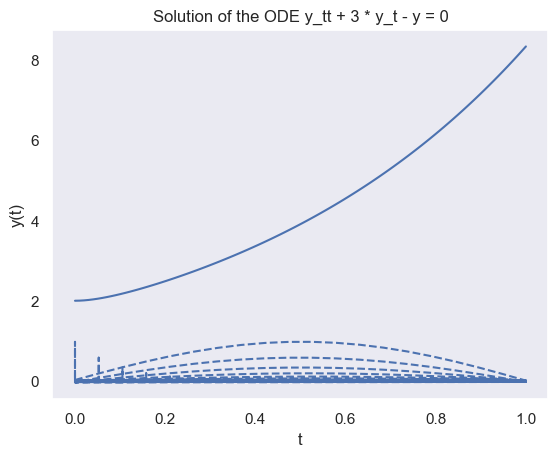

In [36]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def odesys(y, t):
    y1, y2 = y
    dydt = [y2,  # y1' = y2
            y1 - 3*y2]  # y2' = y - 3*y2
    return dydt

# Initial conditions: y(0) = 1, y'(0) = 0
y0 = [2, 0]
t = np.linspace(0, 5, 100)

# Solve ODE
sol = odeint(odesys, y0, t)

# Extract the solution
y_sol = sol[:, 0]

# Plot the solution
plt.plot(t/5, y_sol)
plt.plot(data[2],pinn_inf_model(data[2]).detach().numpy(),"b--",label="Predicción")
plt.xlabel('t')
plt.ylabel('y(t)')
plt.title('Solution of the ODE y_tt + 3 * y_t - y = 0')
plt.grid()
plt.show()